Here, I set to mark areas of the breast ultrasound scans that are cancerous using image segmentation with deep learning. To this goal, I designed a UNet architecture from scratch (in pytorch) which yielded a strong performance measured by Dice index. 

**Dice index was around 70% when averaged over test data samples.**
<br><br>
The analysis steps:
* Import libraries
* Collect data path for images
* Load a subset of data to estimate mean and std for normalization purposes
* Use the mean and std to create image transforms/augmentations
* Separately load data samples into train and test sets
* Visual inspection of data
* Design the UNet
* Instantiate a UNet
* Train the model
* Visualize model performance across epochs
* Save the model
* Visually inspect some of the segmentations in comparison to the ground truth
* Check for potential biases in model performance across cancer types


# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision.io import read_image

import re
import matplotlib as mpl   
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['font.sans-serif'] = ['SimHei']

data_path = 'Dataset_BUSI_with_GT'
from torch.autograd import Variable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Collect image paths

In [2]:
image_list = []

folders = os.listdir(data_path)
for folder in folders:
    #if folder != 'normal':
    files = os.listdir( os.path.join(data_path, folder) )
    for file in files:
        if 'mask' not in file:
            image_list.append(data_path+'/'+folder+'/'+file) 

random.shuffle(image_list)

data_length = len( image_list )

image_list_train = image_list[:np.floor(0.7*data_length).astype(int)]
image_list_test = image_list[np.floor(0.3*data_length).astype(int):]

print( f'Total length of data: {data_length}')

Total length of data: 780


# define hyperparameters

In [201]:
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNEL_LIST = [1, 16, 32, 64]

N_EPOCHS = 60

class_to_inx = {'normal':0,'benign': 1, 'malignant': 2}
inx_to_class = {0:'normal',1: 'benign', 2: 'malignant'}
inx_to_class_ch = {0 :'无结节',1: '良性结节', 2: '恶性结节'}

# Define Data class

In [6]:
class BreastData(Dataset):
    def __init__(self, image_list, data_mode='Train', transform=None):
        self.image_list = image_list
        self.data_mode = data_mode
        self.image_transform = transform[0]
        self.mask_transform = transform[1]
        
    def __len__(self):
        return len(self.image_list)
    
    def extract_cancer_type(self, image_path):
        if 'benign' in image_path:
            cancer_type = 1
        elif 'malignant' in image_path:
            cancer_type = 2
        elif 'normal' in image_path:
            cancer_type = 0
        return cancer_type
    
    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        
        mask_path = image_path.split('.')[0] + '_mask.png'
        mask = Image.open(mask_path).convert('1')
        
        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        cancer_type = self.extract_cancer_type(image_path)
        return image, mask, cancer_type

# Define Tversky loss as a performance metric

In [7]:
class tverskyloss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.reduction = reduction
        
    def forward(self, pred, target):
        loss = 1 - tversky_index(pred, target, alpha=self.alpha, beta=self.beta, reduction=self.reduction)
        return loss

def tversky_index(y_pred, y_true, alpha=0.5, beta=0.5, reduction='mean'):
    # generalization of dice coefficient algorithm
    #   alpha corresponds to emphasis on False Positives
    #   beta corresponds to emphasis on False Negatives (our focus)
    #   if alpha = beta = 0.5, then same as dice
    #   if alpha = beta = 1.0, then same as IoU/Jaccard
    smooth = 1e-5
    
    if y_true.ndim > 3:
        y_true_f = y_true.reshape(y_true.shape[0], -1)
        y_pred_f = y_pred.reshape(y_pred.shape[0], -1)
    else:
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        
    intersection = torch.sum(y_true_f * y_pred_f)
    tversky = (intersection + smooth) / ( intersection + alpha * (torch.sum(y_pred_f*(1 - y_true_f))) + beta *  (torch.sum((1 - y_pred_f)*y_true_f)) + smooth)
    
    if reduction == 'mean':
        tversky = tversky.mean()
    return tversky

# Define image transforms/augmentations

In [8]:
#basic transforms
image_transforms = {}

image_transforms['mask'] = T.Compose([
    T.Resize( int(np.floor(IMAGE_SIZE * 1.05)) ),
    T.ToTensor(),
    T.Grayscale(),
    T.CenterCrop(IMAGE_SIZE)
])



In [9]:
print(torch.__version__)

2.0.1


In [10]:
# find mean and std for normalization purposes
transform = [image_transforms['mask'], image_transforms['mask']]
image_dataset = BreastData(image_list_train, transform=transform)
image_dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=100, shuffle=True)
data_length = len(image_dataset)


In [11]:
subset = next(iter(image_dataloader))[0].permute(1, 0, 2, 3).reshape(1, -1)

mean = subset.mean(-1)
std = subset.std(-1)
print(f'Mean: {mean} --- std: {std}')

Mean: tensor([0.3385]) --- std: tensor([0.2174])


In [12]:
image_transforms['train'] = T.Compose([
    T.Resize( int(np.floor(IMAGE_SIZE * 1.05)) ),
    T.ToTensor(),
    T.Grayscale(),
    T.CenterCrop(IMAGE_SIZE),
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.1, scale=(0.01, 0.1), ratio=(0.2, 5)),
])

image_transforms['test'] = T.Compose([
    T.Resize( int(np.floor(IMAGE_SIZE * 1.05)) ),
    T.ToTensor(),
    T.Grayscale(),
    T.CenterCrop(IMAGE_SIZE),
    T.Normalize(mean=mean, std=std),
])

# data augmentation 
image_transforms['original_complex'] = T.Compose([
    T.Resize( int(np.floor(IMAGE_SIZE * 1.05)) ),
    T.ToTensor(),
    T.ColorJitter(brightness=.1, hue=.1),
    T.Grayscale(),
    T.GaussianBlur(3,0.1),
    T.CenterCrop(IMAGE_SIZE),
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.1, scale=(0.01, 0.1), ratio=(0.2, 5)),
])


# Split Image data into Train and Test sets

In [13]:
train_transform = [image_transforms['original_complex'], image_transforms['mask']]
#train_transform = [image_transforms['train'], image_transforms['mask']]
test_transform = [image_transforms['test'], image_transforms['mask']]

train_dataset = BreastData(image_list_train, transform=train_transform)
test_dataset = BreastData(image_list_test, transform=test_transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

print(f'Train set size: {len(train_dataset)} ----- Test set size: {len(test_dataset)}')

Train set size: 546 ----- Test set size: 546


# Visual inspection of random data samples

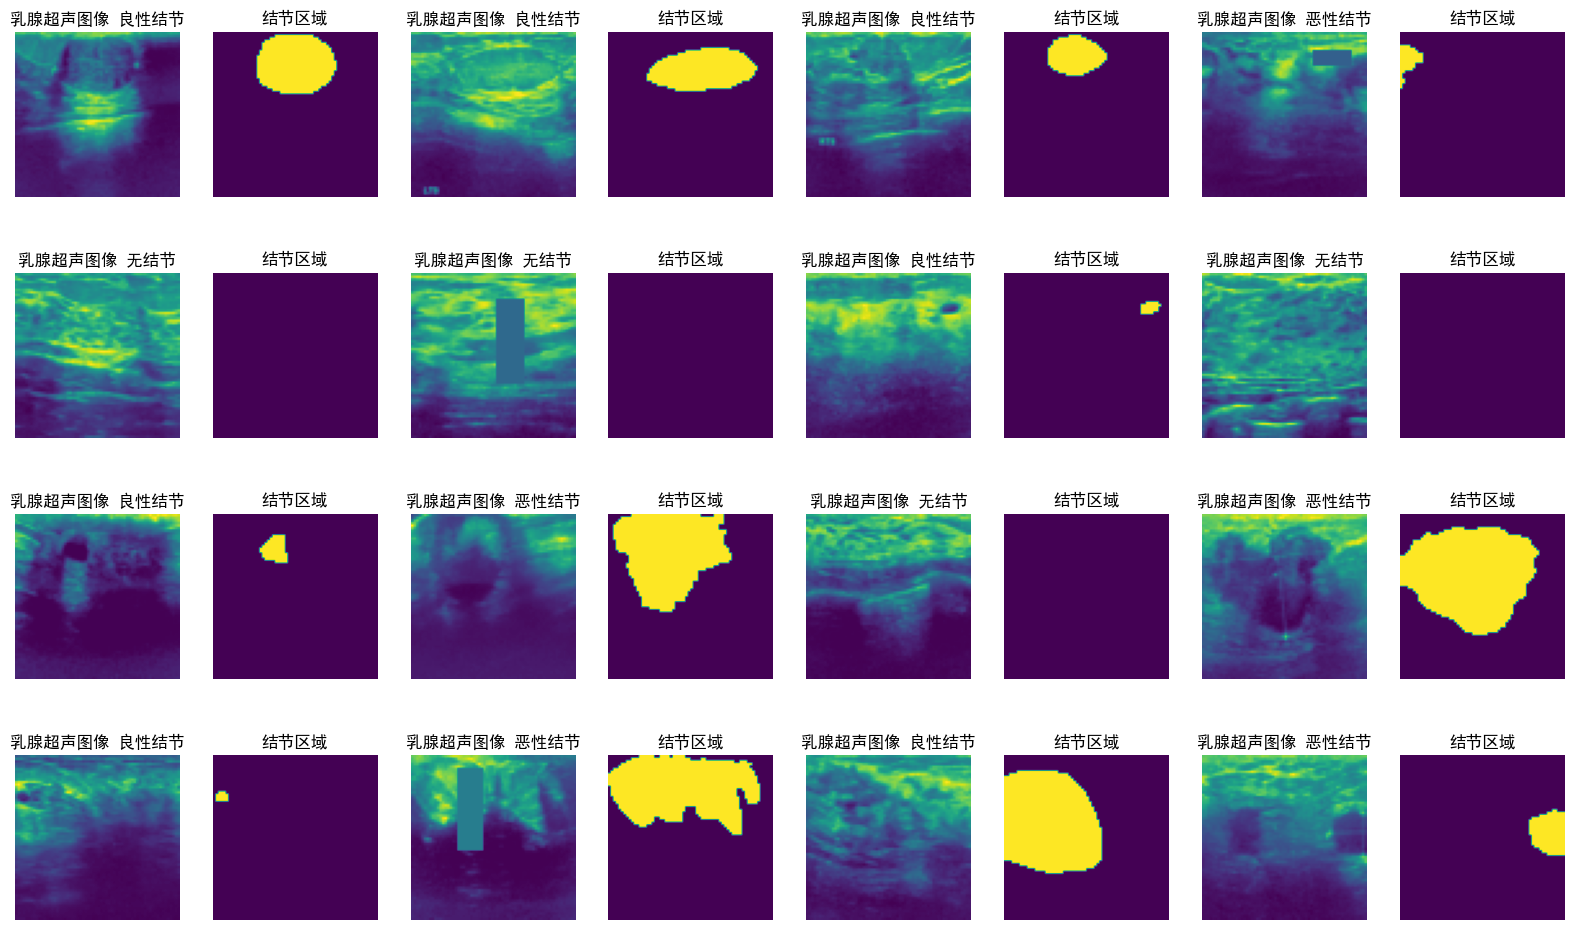

In [14]:
images, masks, labels = next(iter(train_dataloader))
labels = np.array(labels)

fig, ax = plt.subplots(4,8, figsize=(20,12))
ax = ax.ravel()
for a in ax:
    a.axis('off')
    
for ind, (image, mask, label) in enumerate( zip(images, masks, labels) ):
    if ind < 16:
        plt.sca(ax[2 * ind])
        #plt.imshow(image.permute(1,2,0), cmap='gray')
        plt.imshow(image.permute(1,2,0))
        plt.title(f'乳腺超声图像 {inx_to_class_ch[label]}')
        #plt.title(f'#{ind+1}: {inx_to_class_ch[label]}')
        plt.sca(ax[2 * ind + 1])
        plt.imshow(mask.permute(1,2,0))
        #plt.title(f'#{ind+1} 结节区域')
        plt.title(f'结节区域')

# design the attention-based UNet, which learned from the pictures

In [15]:
#序列化地使用两种注意力机制，要比并行化使用效果要好。先使用通道注意力在实际数据对比上要优于先使用空间注意力
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        #平均池化
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        #最大池化
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        #MLP  除以16是降维系数
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False) #kernel_size=1
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        #结果相加
        out = avg_out + max_out
        return self.sigmoid(out)

#空间注意力
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        #声明卷积核为 3 或 7
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        #进行相应的same padding填充
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  #平均池化
        max_out, _ = torch.max(x, dim=1, keepdim=True) #最大池化
        #拼接操作
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x) #7x7卷积填充为3，输入通道为2，输出通道为1
        return self.sigmoid(x)

class CBAMLayer(nn.Module):
    def __init__(self, channel, reduction=16, spatial_kernel=7):
        super(CBAMLayer, self).__init__()
 
        # channel attention 压缩H,W为1
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
 
        # shared MLP
        self.mlp = nn.Sequential(
            # Conv2d比Linear方便操作
            # nn.Linear(channel, channel // reduction, bias=False)
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            # inplace=True直接替换，节省内存
            nn.ReLU(inplace=True),
            # nn.Linear(channel // reduction, channel,bias=False)
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
 
        # spatial attention
        self.conv = nn.Conv2d(2, 1, kernel_size=spatial_kernel,
                              padding=spatial_kernel // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        max_out = self.mlp(self.max_pool(x))
        avg_out = self.mlp(self.avg_pool(x))
        channel_out = self.sigmoid(max_out + avg_out)
        x = channel_out * x
 
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        spatial_out = self.sigmoid(self.conv(torch.cat([max_out, avg_out], dim=1)))
        x = spatial_out * x
        return x



In [187]:
class unet(nn.Module):
    def __init__(self, CHANNEL_LIST):
        super().__init__()
        self.encoder_block = encoder(CHANNEL_LIST[:-1]) # 128 channels
        self.flat_block = conv_block(CHANNEL_LIST[-2], CHANNEL_LIST[-1]) # 256 channels
        self.bottle_block = CBAMLayer(64)
        self.decoder_block = decoder(CHANNEL_LIST[::-1][:-1]) 
        self.output_block = conv_block(CHANNEL_LIST[1], 1) 
        self.smooth_block = smooth_block() # filter small false positive results
        
    def forward(self, x):
        #print(x.shape)
        encoder_outputs, x = self.encoder_block(x)
        #print(x.shape)
        x = self.flat_block(x)
        #print(x.shape)
        x = self.bottle_block(x)
        x = self.decoder_block(x, encoder_outputs)
       # print(x.shape)
        x = self.output_block(x)
        x = f.sigmoid(self.smooth_block(x))
        
        return x    
        
class smooth_block(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(1, 2, 5)  #maybe kernal size = 3 is better
        self.conv2 = conv_block(2, 1, 5)
        self.conv3 = conv_block(1, 2, 3)
        self.conv4 = conv_block(2, 1, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernal=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernal, padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)        
        self.dropout = nn.Dropout2d(0.02)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernal, padding='same')
    
    def forward(self, x):
        x = self.dropout( f.relu( self.batchnorm1( self.conv1(x) ) ) )
        x = self.conv2(x)
        return x
    
    
class encoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
        self.maxpool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        encoder_outputs = []
        for block in self.blocks:
            x = block(x)
            encoder_outputs.append(x)
            x = self.maxpool(x)
        return encoder_outputs, x
    
class decoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.upsamples = nn.ModuleList([
            nn.ConvTranspose2d(channel_list[i], channel_list[i+1], 2, 2)  
            for i in range(len(channel_list)-1)
        ])
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
        self.attention_blocks = nn.ModuleList([
            CBAMLayer(channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
      
    
    def forward(self, x, encoder_outputs):
        encoder_outputs_reversed = encoder_outputs[::-1]

        for ind, (upsample, block, attention) in enumerate( zip(self.upsamples, self.blocks, self.attention_blocks) ):            
            x = upsample(x) # doubles the spatial dimension and decrease channels
            x = torch.cat([x, encoder_outputs_reversed[ind]], dim=1) # channels are increased again
            x = block(x) # decrease number of channels
            x = x + attention(x)
        return x
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)

# Instantiate the model

In [192]:
UNet = unet(CHANNEL_LIST).to(device)
initialize_weights(UNet)

criterion = tverskyloss(alpha=0.5, beta=0.5)

optimizer = optim.AdamW(UNet.parameters(), lr=0.01,weight_decay=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.1)

# Train the model

In [193]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
lrs = []

for epoch in range(N_EPOCHS):
    UNet.train()
    
    current_lr = optimizer.state_dict()['param_groups'][0]['lr'] 
    lrs.append( current_lr )
    
    running_loss = 0
    running_metric = 0
    
    for (images, masks, _) in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        output = UNet(images)
        
        # loss 
        loss = criterion(output, masks)
        running_loss += loss.item() * images.shape[0]
        
        # accuracy metric
        img1 = torch.where(output.detach().cpu() >= 0.5, 1, 0)
        img2 = masks.detach().cpu()
        running_metric = running_metric + tversky_index(img1, img2) * images.shape[0]

        loss.backward()
        optimizer.step()
        
    lr_scheduler.step( running_loss )

    train_losses.append( running_loss / len(train_dataset) )
    train_metrics.append( running_metric / len(train_dataset) * 100 )
    

    with torch.no_grad():
        UNet.eval()
        
        running_loss = 0
        running_metric = 0
        for (images, masks, _) in test_dataloader:
            images = images.to(device)
            masks = masks.to(device)
        
            output = UNet(images)
            
            # loss
            loss = criterion(output, masks)
            running_loss += loss.item() * images.shape[0]
        
            # accuracy metric
            img1 = torch.where(output.detach().cpu() >= 0.5, 1, 0)
            img2 = masks.detach().cpu()
            running_metric = running_metric + tversky_index(img1, img2) * images.shape[0]
        
        test_losses.append( running_loss / len(test_dataset) )
        test_metrics.append( running_metric / len(test_dataset) * 100 )
        
    print(f'[{epoch+1}/{N_EPOCHS}]: train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f} -------------  train_tversky={train_metrics[-1]:0.2f} / test_tversky={test_metrics[-1]:0.2f} -------------  lr={current_lr:0.8f}')

[1/150]: train_loss=0.79 / test_loss=0.78 -------------  train_tversky=22.65 / test_tversky=22.91 -------------  lr=0.10000000
[2/150]: train_loss=0.72 / test_loss=0.76 -------------  train_tversky=28.63 / test_tversky=24.34 -------------  lr=0.10000000
[3/150]: train_loss=0.71 / test_loss=0.76 -------------  train_tversky=28.91 / test_tversky=24.26 -------------  lr=0.10000000
[4/150]: train_loss=0.66 / test_loss=0.68 -------------  train_tversky=34.37 / test_tversky=35.33 -------------  lr=0.10000000
[5/150]: train_loss=0.65 / test_loss=0.65 -------------  train_tversky=35.52 / test_tversky=35.38 -------------  lr=0.10000000
[6/150]: train_loss=0.63 / test_loss=0.58 -------------  train_tversky=36.73 / test_tversky=41.72 -------------  lr=0.10000000
[7/150]: train_loss=0.62 / test_loss=0.60 -------------  train_tversky=37.87 / test_tversky=40.19 -------------  lr=0.10000000
[8/150]: train_loss=0.60 / test_loss=0.81 -------------  train_tversky=39.67 / test_tversky=19.35 -------------

KeyboardInterrupt: 

# Visualizer model performance across epochs

Text(0, 0.5, 'Learning rate')

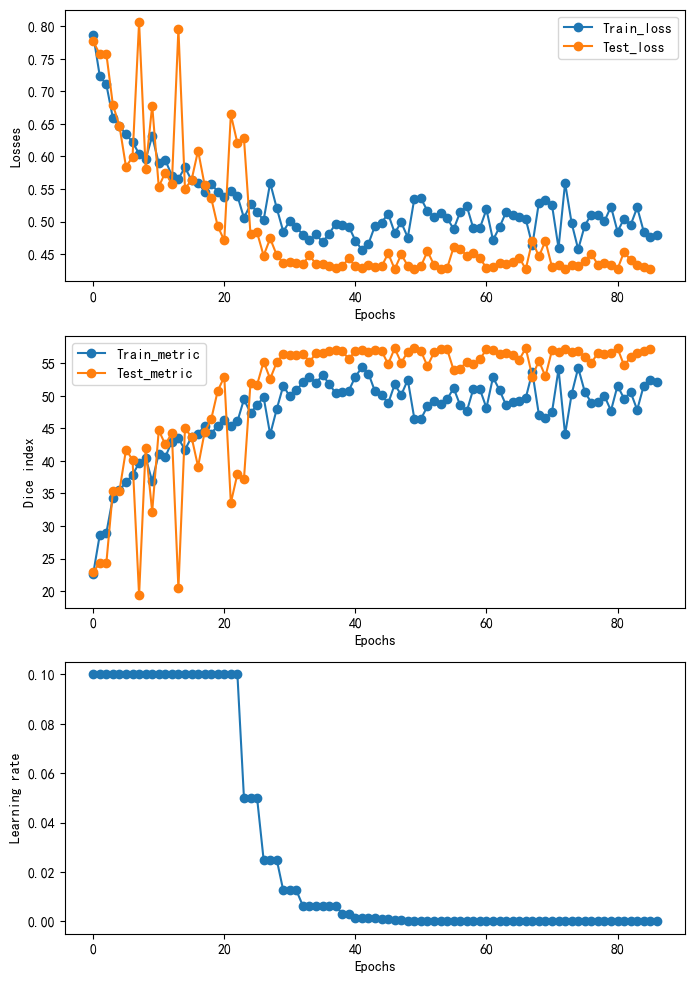

In [194]:
fig, ax = plt.subplots(3, 1, figsize=(8,12))
ax[0].plot(np.array(train_losses), marker='o', label='Train_loss')
ax[0].plot(np.array(test_losses), marker='o', label='Test_loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')

ax[1].plot(np.array(train_metrics), marker='o', label='Train_metric')
ax[1].plot(np.array(test_metrics), marker='o', label='Test_metric')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Dice index')

ax[2].plot(np.array(lrs), marker='o', label='Train_accuracy')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning rate')

# Save the model

In [195]:
torch.save(UNet, r'./saved/trained_model_UNet')

# Visually inspect segmentations

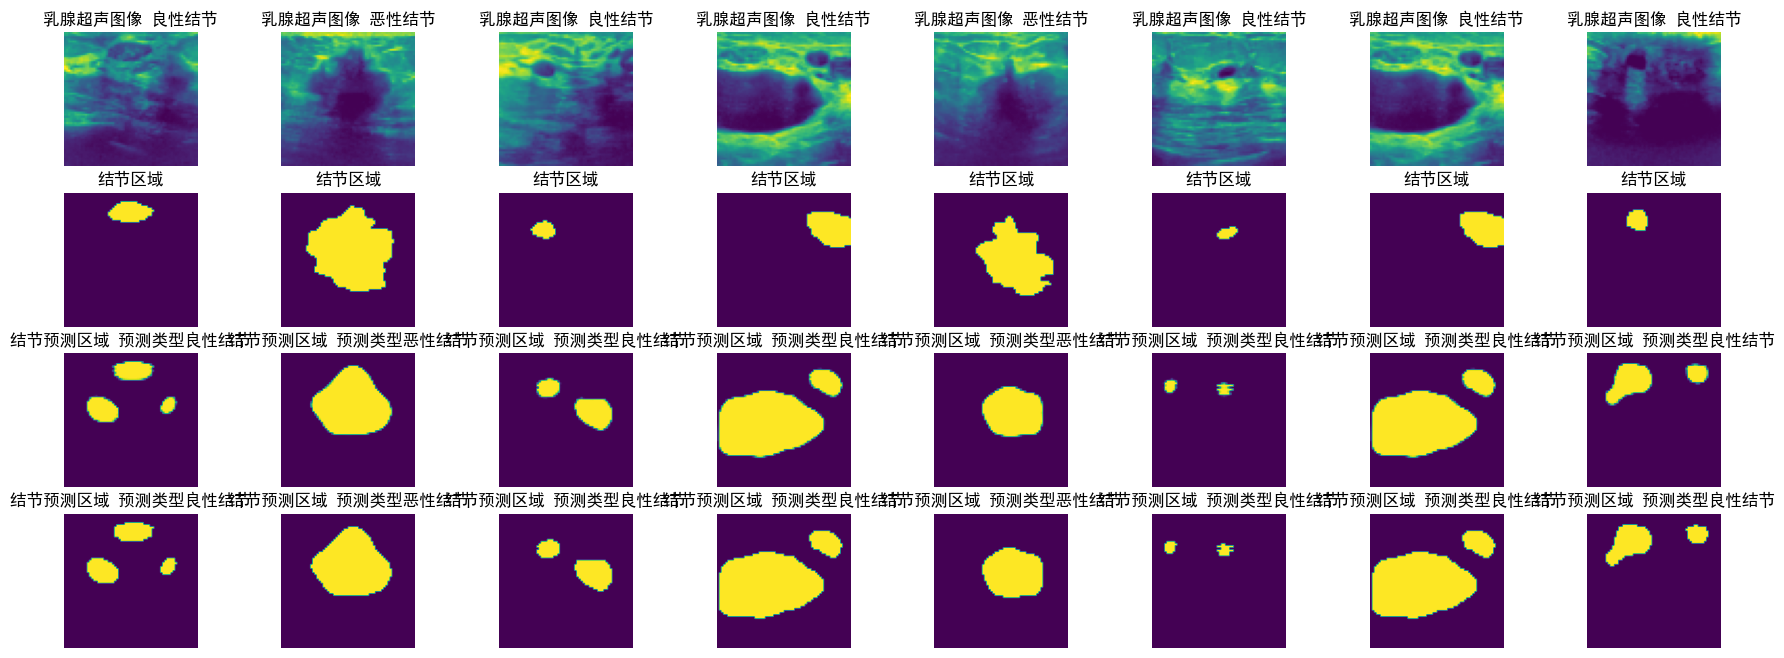

In [196]:
fig, ax = plt.subplots(4, 8, figsize=(22, 8))
for this_ax in ax.ravel():
    this_ax.axis('off')
    
for counter, ind in enumerate(np.random.choice(np.arange(len(test_dataset)), 8)):
    image, mask, cancer_type = test_dataset[ind]
    
    ax[0, counter].imshow( image.permute(1,2,0) )
    ax[0, counter].set_title('乳腺超声图像 '+inx_to_class_ch[cancer_type])
    
    ax[1, counter].imshow( mask.permute(1,2,0) )
    ax[1, counter].set_title('结节区域')

    segmentation = UNet(torch.unsqueeze(image, 0).to(device))
    ax[2, counter].imshow( torch.squeeze(segmentation.detach().cpu(), 0).permute(1,2,0) )
    ax[2, counter].set_title('结节预测区域 预测类型'+ inx_to_class_ch[cancer_type])
    
    segmentation = (segmentation.detach().cpu() > 0.5)
    ax[3, counter].imshow( torch.squeeze(segmentation, 0).permute(1,2,0) )
    ax[3, counter].set_title('结节预测区域 预测类型'+ inx_to_class_ch[cancer_type])

# Check for possible biases in model performance per cancer type

In [ ]:
mask.shape

In [46]:
jaccard_index_per_type = {key: [] for key in class_to_inx.keys()}

for (image, mask, label) in test_dataset:
    image = torch.unsqueeze(image, 0).cpu()
    mask = torch.unsqueeze(mask, 0).cpu()
    UNet = UNet.cpu()
    segmentation = torch.where(UNet(image).detach() > 0.5, 1, 0)
    j = tversky_index(segmentation, mask)
    
    key = inx_to_class[label]
    jaccard_index_per_type[key].append( j )

jaccard_index_per_type = {key: np.array(val) for key, val in jaccard_index_per_type.items()}

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

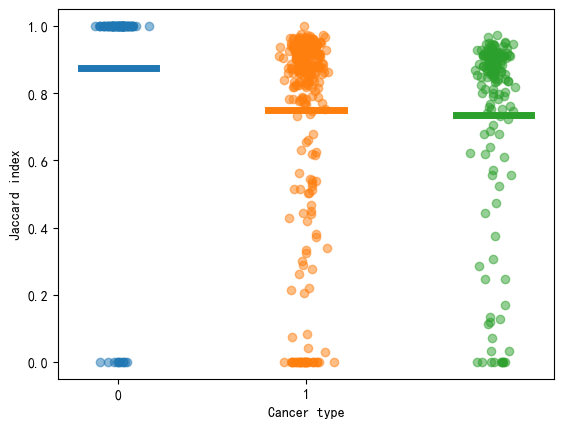

In [47]:
for ind, (key, val) in enumerate(jaccard_index_per_type.items()):
    X = ind + np.random.randn(val.size) * 0.05
    plt.scatter(X, val, alpha=0.5)
    plt.plot([ind-0.2, ind+0.2], [val.mean(), val.mean()], linewidth=5)

plt.xlabel('Cancer type')
plt.ylabel('Jaccard index')

_ = plt.xticks(ticks=[0, 1], labels=jaccard_index_per_type.keys())
percentage = jaccard_index_per_type['benign'].mean() / jaccard_index_per_type['malignant'].mean() * 100

if percentage > 100:
    key_better = 'benign'
else:
    key_better = 'malignant'
percentage = abs( percentage - 100 )
print(f'Model performs better for class "{key_better}" by [{percentage:0.2f}] percent in Dice index.')

## Train the classificationNet 2: The probability based model

In [197]:
class probabilityClassifyNet(nn.Module):
    def __init__(self, CHANNEL_LIST):
        super().__init__()
        self.encoder_block = encoder(CHANNEL_LIST[:-1]) # 128 channels
        self.flat_block = conv_block(CHANNEL_LIST[-2], 16)
        self.bottle_block = CBAMLayer(16)
        self.decoder_block = decoder(CHANNEL_LIST[::-1][:-1]) 
        self.output_block = conv_block(16, 1) 
        self.smooth_block = smooth_block()
        self.classify_block = classify_block2(256,3) 
        
    def forward(self, x):
        #print(x.shape)
        encoder_outputs, x = self.encoder_block(x)
        #print(x.shape)
        x = self.flat_block(x)
        #print(x.shape)
        xx = self.bottle_block(x)
        #print(x.shape)
        #x = self.decoder_block(x, encoder_outputs)
        #print(x.shape)
        x = self.output_block(x)
        #print(x.shape)
        x = self.smooth_block(x)
        x = self.classify_block(x,xx)

        return x    
        
class classify_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.node_decoder = nn.Sequential(
            nn.Dropout2d(0.02),nn.BatchNorm1d(256),nn.Linear(256, 1), nn.Sigmoid()
        )
        self.cancer_decoder = nn.Sequential(
           nn.Dropout2d(0.02),nn.BatchNorm1d(4096),nn.Linear(4096, 2),nn.Softmax()
        )
        self.out_put_size = out_channels
        self.softmax = nn.Softmax()
 

    def forward(self, segment,compressed):
        shape = segment.shape
        segment = segment.flatten(1,3)
        node_pro = self.node_decoder(segment)

        compressed = compressed.flatten(1,3)
        cancer_pro = self.cancer_decoder(compressed)

    
        # x = torch.cat((1-node_pro
        #                ,(1-cancer_pro)/node_pro, cancer_pro/node_pro), 1)
        
        x = torch.cat((1-node_pro
                       ,cancer_pro[:,0].view(-1,1)*node_pro, cancer_pro[:,1].view(-1,1)*node_pro), 1)
        return x

class classify_block2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.node_decoder = nn.Sequential(
            nn.Dropout2d(0.02),nn.BatchNorm1d(256),nn.Linear(256, 1)
        )
        self.cancer_decoder = nn.Sequential(
           nn.Dropout2d(0.02),nn.BatchNorm1d(4096),nn.Linear(4096, 2)
        )
        self.out_put_size = out_channels
        self.softmax = nn.Softmax()
 

    def forward(self, segment,compressed):
        shape = segment.shape
        segment = segment.flatten(1,3)
        node_pro = self.node_decoder(segment)

        compressed = compressed.flatten(1,3)
        cancer_pro = self.cancer_decoder(compressed)

    
        # x = torch.cat((1-node_pro
        #                ,(1-cancer_pro)/node_pro, cancer_pro/node_pro), 1)
        
        x = self.softmax(torch.cat((node_pro,cancer_pro), 1))
        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernal=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernal, padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)        
        self.dropout = nn.Dropout2d(0.02)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernal, padding='same')
    
    def forward(self, x):
        x = self.dropout( f.relu( self.batchnorm1( self.conv1(x) ) ) )
        x = self.conv2(x)
        return x
    
    
class encoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
        self.maxpool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        encoder_outputs = []
        for block in self.blocks:
            x = block(x)
            encoder_outputs.append(x)
            x = self.maxpool(x)
        return encoder_outputs, x
    
class decoder(nn.Module):
    def __init__(self, channel_list):
        super().__init__()
        self.upsamples = nn.ModuleList([
            nn.ConvTranspose2d(channel_list[i], channel_list[i+1], 2, 2)  
            for i in range(len(channel_list)-1)
        ])
        self.blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
        self.attention_blocks = nn.ModuleList([
            CBAMLayer(channel_list[i+1])
            for i in range(len(channel_list)-1)
        ])
      
    
    def forward(self, x, encoder_outputs):
        encoder_outputs_reversed = encoder_outputs[::-1]

        for ind, (upsample, block, attention) in enumerate( zip(self.upsamples, self.blocks, self.attention_blocks) ):            
            x = upsample(x) # doubles the spatial dimension and decrease channels
            x = torch.cat([x, encoder_outputs_reversed[ind]], dim=1) # channels are increased again
            x = block(x) # decrease number of channels
            x = x + attention(x)
        return x
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)
        if isinstance(m,nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)

In [198]:

ClassprobabilityClassifyNetifyNet = probabilityClassifyNet(CHANNEL_LIST).to(device)
initialize_weights(ClassprobabilityClassifyNetifyNet)
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(ClassprobabilityClassifyNetifyNet.parameters(), lr=0.001,weight_decay=1)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

In [202]:

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
lrs = []

for epoch in range(N_EPOCHS):
   
    ClassprobabilityClassifyNetifyNet.train()
    
    current_lr = optimizer.state_dict()['param_groups'][0]['lr'] 
    lrs.append( current_lr )
    
    running_loss = 0
    running_metric = 0
    
    for (images, _, labels) in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        output = ClassprobabilityClassifyNetifyNet(images)
        
        #print(images.shape,output.shape,labels.shape)
        # loss 
        loss = criterion(output, labels)
        running_loss += loss.item() * images.shape[0]
        

        loss.backward()
        optimizer.step()
    print(output[0])
    lr_scheduler.step( running_loss )

    train_losses.append( running_loss / len(train_dataset) )


    with torch.no_grad():
        ClassprobabilityClassifyNetifyNet.eval()
        
        running_loss = 0
        running_metric = 0
        for (images, _, labels) in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = ClassprobabilityClassifyNetifyNet(images)
            
        

            # loss
            loss = criterion(output, labels)
            running_loss += loss.item() * images.shape[0]
        
        
        test_losses.append( running_loss / len(test_dataset) )

    print(f'[{epoch+1}/{N_EPOCHS}]: train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f}-------------  lr={current_lr:0.8f}')

/tmp/ipykernel_2646691/823518832.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(torch.cat((node_pro,cancer_pro), 1))


tensor([0.0086, 0.9763, 0.0151], device='cuda:0', grad_fn=<SelectBackward0>)
[1/60]: train_loss=0.77 / test_loss=0.80-------------  lr=0.00100000
tensor([0.1991, 0.0671, 0.7338], device='cuda:0', grad_fn=<SelectBackward0>)
[2/60]: train_loss=0.77 / test_loss=0.79-------------  lr=0.00100000
tensor([0.0066, 0.9886, 0.0048], device='cuda:0', grad_fn=<SelectBackward0>)
[3/60]: train_loss=0.77 / test_loss=0.79-------------  lr=0.00100000
tensor([0.0261, 0.0087, 0.9652], device='cuda:0', grad_fn=<SelectBackward0>)
[4/60]: train_loss=0.77 / test_loss=0.80-------------  lr=0.00100000
tensor([0.0039, 0.9935, 0.0026], device='cuda:0', grad_fn=<SelectBackward0>)
[5/60]: train_loss=0.75 / test_loss=0.77-------------  lr=0.00100000
tensor([0.8649, 0.0634, 0.0718], device='cuda:0', grad_fn=<SelectBackward0>)
[6/60]: train_loss=0.74 / test_loss=0.77-------------  lr=0.00100000
tensor([1.6330e-04, 9.9982e-01, 1.7831e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)
[7/60]: train_loss=0.73 / te

In [28]:
from sklearn.metrics import f1_score,confusion_matrix
is_node = []
is_node_label = []

is_cancer = []
is_cancer_label = []
full_test_dataloader = DataLoader(test_dataset, shuffle=False)

for images, _, labels in(full_test_dataloader):
    prob = ClassprobabilityClassifyNetifyNet(images.to(device)) #表示模型的预测输出
    prob = prob.cpu().detach().numpy() #先把prob转到CPU上，然后再转成numpy，如果本身在CPU上训练的话就不用先转成CPU了
    predict = np.argmax(prob,axis=1)
    for p in predict:
        if p !=0:p = 1
        else: p=0
        is_node.append(p) #求每一行的最大值索引
        
    for l in labels:
        if l !=0:
            l = 1
        is_node_label.append(l)
print("F1-Score:{:.4f}".format(f1_score(is_node_label,is_node)))
print(classification_report(is_node_label,is_node,labels=[0,1]))

print(confusion_matrix(is_node_label, is_node, labels=[0,1]))

ModuleNotFoundError: No module named 'sklearn'

In [29]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score,classification_report
predict = np.array([])
label = np.array([])

full_test_dataloader = DataLoader(test_dataset, shuffle=False)
for images, _, labels in(full_test_dataloader):
    prob = ClassprobabilityClassifyNetifyNet(images.to(device)) #表示模型的预测输出
    prob = prob.cpu().detach().numpy() #先把prob转到CPU上，然后再转成numpy，如果本身在CPU上训练的话就不用先转成CPU了
    _predict = np.argmax(prob,axis=1)

    predict = np.append(predict,_predict) #求每一行的最大值索引
    label=np.append(label,labels.cpu().detach().numpy())
    

print(label,'\n')
print(predict)

print('Micro precision', precision_score(label, predict, average='micro'))
print('Micro recall', recall_score(label, predict, average='micro'))
print("Micro F1-Score:{:.4f}".format(f1_score(label,predict,average='micro')))
print(classification_report(label,predict,labels=[0,1,2]))
print(confusion_matrix(label, predict, labels=[0,1,2]))

ModuleNotFoundError: No module named 'sklearn'

# Visualizer model performance across epochs

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8,12))
ax[0].plot(np.array(train_losses), marker='o', label='Train_loss')
ax[0].plot(np.array(test_losses), marker='o', label='Test_loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')


ax[1].plot(np.array(lrs), marker='o', label='Train_accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Learning rate')

# Save model

In [270]:
torch.save(ClassprobabilityClassifyNetifyNet, r'./saved/trained_model_probabilityClassifyNet')

PicklingError: Can't pickle <class '__main__.conv_block'>: it's not the same object as __main__.conv_block

# Visually inspect classification

/tmp/ipykernel_2646691/823518832.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(torch.cat((node_pro,cancer_pro), 1))


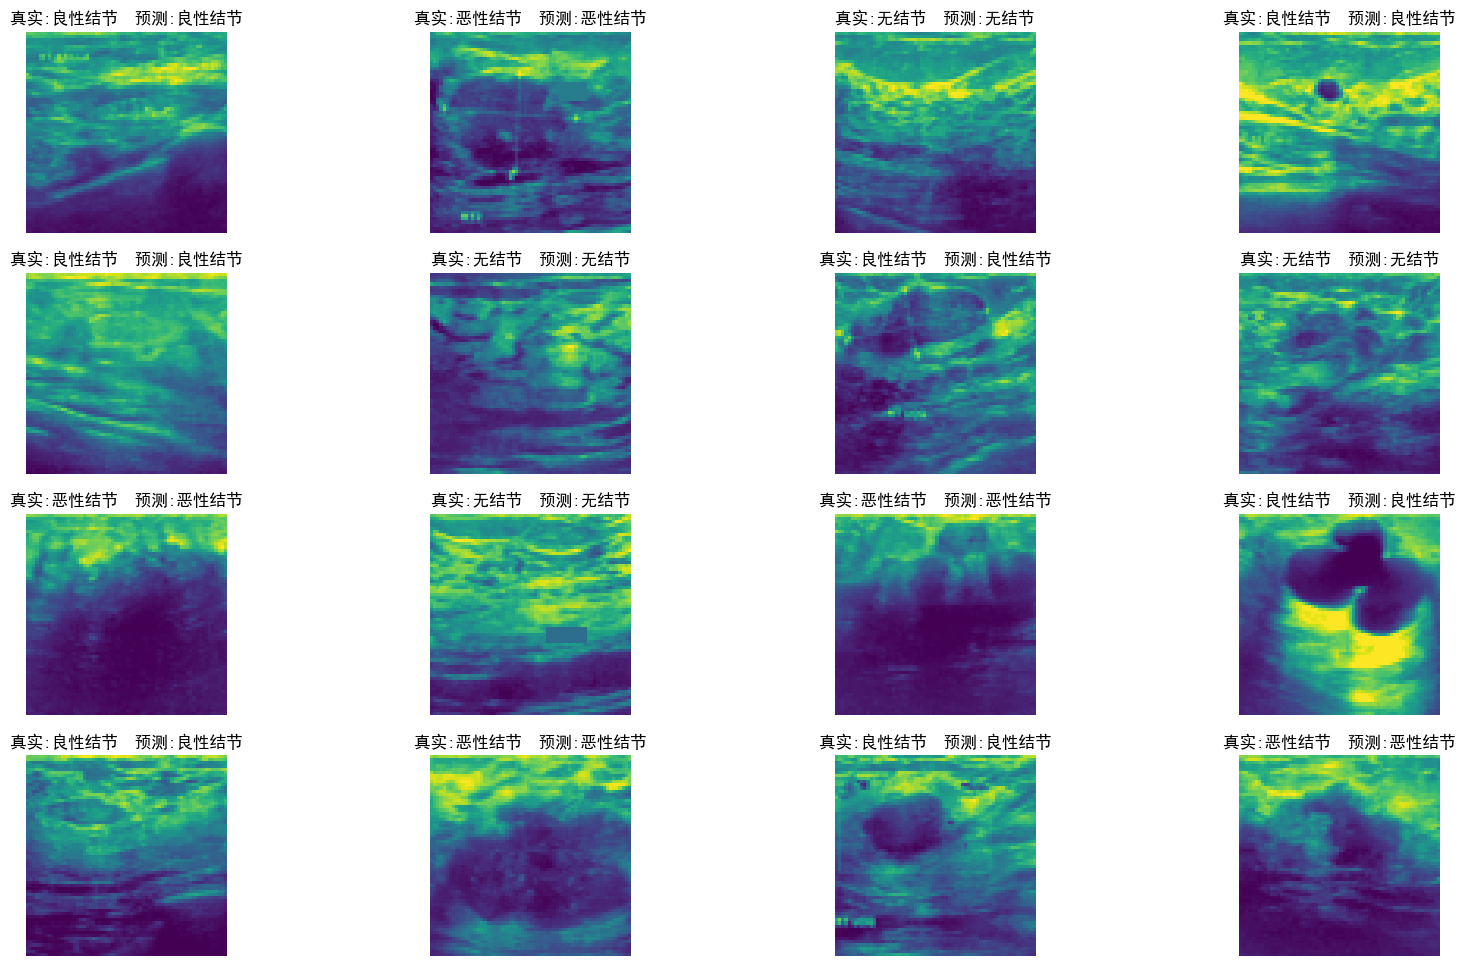

In [220]:
images, masks, labels = next(iter(train_dataloader))
labels = np.array(labels)

fig, ax = plt.subplots(4,4, figsize=(20,12))
ax = ax.ravel()
for a in ax:
    a.axis('off')

def predict(model,img):
    model = model.eval()
    inx = model(img.to(device).view(1,1,64,64))
    inx = torch.argmax(inx).cpu()
    lable = inx_to_class_ch[int(inx)]
    return lable
    
for ind, (image, mask, label) in enumerate( zip(images, masks, labels) ):
    if ind < 16:
        plt.sca(ax[ind])
        plt.imshow(image.permute(1,2,0))
        plt.title(f'真实:{inx_to_class_ch[label]}  预测:{predict(ClassprobabilityClassifyNetifyNet,image)}')

# fusion model

In [453]:
class fusionNet(nn.Module):
    def __init__(self, CHANNEL_LIST):
        super().__init__()
  
        self.fusion_block = fusion_block() 
        
    def forward(self, label, mask):
        label = self.fusion_block(mask, label)
        return label    


        
class fusion_block(nn.Module):
    def __init__(self, ):
        super().__init__()
  
        self.scale =  nn.Sequential(nn.BatchNorm1d(3),nn.Linear(3,256),nn.ReLU(), nn.Dropout2d(0.02),
                                    nn.BatchNorm1d(256),nn.Linear(256,256),nn.ReLU(),nn.Dropout2d(0.02),
                                    nn.BatchNorm1d(256),nn.Linear(256,256),nn.ReLU(),nn.Dropout2d(0.02),
                                    nn.BatchNorm1d(256),nn.Linear(256,2),nn.ReLU(),
                                   )
       
        self.img_decoder = nn.Sequential(
            nn.AdaptiveMaxPool2d(1)
                                   )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        self.apha1 = nn.Parameter(torch.tensor([1.0],device=device, ),requires_grad=True)
        self.apha2 = nn.Parameter(torch.tensor([1.0],device=device, ),requires_grad=True)
        self.apha3 = nn.Parameter(torch.tensor([1.0],device=device, ),requires_grad=True)
        self.register_parameter('apha1',self.apha1)
        self.register_parameter('apha2',self.apha2)
        self.register_parameter('apha3',self.apha3)
       

    def forward(self,mask,label):
        # if self.training:
        #     self.apha1.requires_grad=True
        #     self.apha2.requires_grad=True
        #     self.apha3.requires_grad=True
        # else:
        #     self.apha1.requires_grad=False
        #     self.apha2.requires_grad=False
        #     self.apha3.requires_grad=False
        
        label = label.view(-1,3)
        # mask = mask.view(-1,3,1)
        node_pro = self.img_decoder(mask).view(-1,1)
        caner_pro = self.scale(label).view(-1,2)
      
        x = self.softmax(torch.cat((1-node_pro, caner_pro[:,0].view(-1,1)*node_pro,caner_pro[:,1].view(-1,1)*node_pro), 1).view(-1,3))

        # # x = torch.where(x<0.5, 0, x)

        apha1 = self.sigmoid(self.apha1)
        apha2 = self.sigmoid(self.apha2)
        apha3 = self.sigmoid(self.apha3)

        # label = label + x
        
        # y1 = apha1*label[:,0].clone() 
        # y2 = apha2*label[:,1].clone().view(-1,1) + (1-apha2)*caner_pro[:,0].view(-1,1)*node_pro
        # y3 = apha3*label[:,2].clone().view(-1,1) + (1-apha3)*caner_pro[:,1].view(-1,1)*node_pro

        # test lost 0.50
        y1 = apha1*label[:,0].clone().view(-1,1) + (1-apha1)*x[:,0].view(-1,1)
        y2 = apha2*label[:,1].clone().view(-1,1) + (1-apha2)*x[:,1].view(-1,1)
        y3 = apha3*label[:,2].clone().view(-1,1) + (1-apha3)*x[:,2].view(-1,1)
        y1 = y1.view(-1,1)
        y2 = y2.view(-1,1)
        y3 = y3.view(-1,1)
        # print(y1.shape,y2.shape,y3.shape)
        y = torch.cat((y1,y2,y3), 1).view(-1,3)
        # y = torch.cat((y1,y2*(1-y1),y3*(1-y1)), 1).view(-1,3)
        y = self.softmax(y)
        return y


        
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernal=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernal, padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)        
        self.dropout = nn.Dropout2d(0.02)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernal, padding='same')
    
    def forward(self, x):
        x = self.dropout( f.relu( self.batchnorm1( self.conv1(x) ) ) )
        x = self.conv2(x)
        return x
    
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0, 0.02)
        if isinstance(m,nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)

In [454]:

FusionNet = fusionNet(CHANNEL_LIST).to(device)
initialize_weights(FusionNet)
criterion = nn.CrossEntropyLoss()
# l = list([FusionNet.parameters()]+[FusionNet.fusion_block.apha1,FusionNet.fusion_block.apha2,FusionNet.fusion_block.apha3])
optimizer = optim.AdamW(FusionNet.parameters(), lr=0.001,weight_decay=1)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

In [ ]:

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
lrs = []

for epoch in range(N_EPOCHS):
   
    FusionNet.train()
    
    current_lr = optimizer.state_dict()['param_groups'][0]['lr'] 
    lrs.append( current_lr )
    
    running_loss = 0
    running_metric = 0
    
    for (images, masks, labels) in train_dataloader:
        images = images.to(device)
        real_labels = labels.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        labels = ClassprobabilityClassifyNetifyNet(images)
        masks = UNet(images)
        output = FusionNet(labels,masks)
        
        #print(images.shape,output.shape,labels.shape)
        # loss 
        loss = criterion(output, real_labels)
        running_loss += loss.item() * images.shape[0]
        

        loss.backward()
        optimizer.step()
    print(output[0])
    lr_scheduler.step( running_loss )

    train_losses.append( running_loss / len(train_dataset) )


    with torch.no_grad():
        FusionNet.eval()
        
        running_loss = 0
        running_metric = 0
        for (images, masks, labels) in test_dataloader:
            images = images.to(device)
            real_labels = labels.to(device)
            masks = masks.to(device)

            
            labels = ClassprobabilityClassifyNetifyNet(images)
            masks = UNet(images)
            output = FusionNet(labels,masks)
        
            
        

            # loss
            loss = criterion(output, real_labels)
            running_loss += loss.item() * images.shape[0]
        
        
        test_losses.append( running_loss / len(test_dataset) )

    print(f'[{epoch+1}/{N_EPOCHS}]: train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f}-------------  lr={current_lr:0.8f}')

/tmp/ipykernel_2646691/823518832.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(torch.cat((node_pro,cancer_pro), 1))


tensor([7.1487e-01, 2.9485e+00, 2.1956e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)
[1/60]: train_loss=0.33 / test_loss=0.50-------------  lr=0.00100000
tensor([4.3771e-03, 6.8277e-04, 4.4068e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)
[2/60]: train_loss=0.31 / test_loss=0.52-------------  lr=0.00100000
tensor([0.0269, 0.6787, 1.0114], device='cuda:0', grad_fn=<SelectBackward0>)
[3/60]: train_loss=0.30 / test_loss=0.51-------------  lr=0.00100000
tensor([3.8808e-03, 4.9055e+00, 4.4637e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [420]:
torch.save(FusionNet, r'./saved/trained_model_FusionNet')

In [325]:
FusionNet= torch.load( r'./saved/trained_model_FusionNet')

# load model

In [23]:
UNet= torch.load( r'./saved/trained_model_UNet')

In [28]:
ClassprobabilityClassifyNetifyNet = torch.load( r'./saved/trained_model_probabilityClassifyNet')

In [361]:
ClassifyNet= torch.load( r'./saved/trained_model_classifyNet')

AttributeError: Can't get attribute 'classifyNet' on <module '__main__'>

#  Visual segmentation and classification

In [416]:
FusionNet.state_dict

<bound method Module.state_dict of fusionNet(
  (fusion_block): fusion_block(
    (scale): Sequential(
      (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=3, out_features=256, bias=True)
      (2): ReLU()
      (3): Dropout2d(p=0.02, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=256, out_features=256, bias=True)
      (6): ReLU()
      (7): Dropout2d(p=0.02, inplace=False)
      (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): ReLU()
      (11): Dropout2d(p=0.02, inplace=False)
      (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Linear(in_features=256, out_features=2, bias=True)
      (14): ReLU()
    )
    (img_decoder): Sequential(
      (0): AdaptiveMaxPool2d(outp

In [441]:
FusionNet.fusion_block.apha1

Parameter containing:
tensor([0.5443], device='cuda:0', requires_grad=True)

In [442]:
FusionNet.fusion_block.apha2

Parameter containing:
tensor([0.7350], device='cuda:0', requires_grad=True)

In [443]:
FusionNet.fusion_block.apha3

Parameter containing:
tensor([0.6997], device='cuda:0', requires_grad=True)

/tmp/ipykernel_2646691/823518832.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(torch.cat((node_pro,cancer_pro), 1))


tensor([[0.4062, 0.0203, 0.0212]]) tensor([[0.9383, 0.0300, 0.0317]])
tensor([[9.9811e-01, 3.9776e+00, 2.3479e-03]]) tensor([[0.0030, 0.9935, 0.0035]])
tensor([[0.4802, 0.1153, 0.0054]]) tensor([[0.8213, 0.1706, 0.0081]])
tensor([[0.9957, 3.9443, 0.0055]]) tensor([[0.0068, 0.9850, 0.0082]])
tensor([[9.9740e-01, 4.0040e+00, 2.4726e-04]]) tensor([[4.1158e-03, 9.9551e-01, 3.7008e-04]])
tensor([[9.9740e-01, 4.0040e+00, 2.4726e-04]]) tensor([[4.1158e-03, 9.9551e-01, 3.7008e-04]])


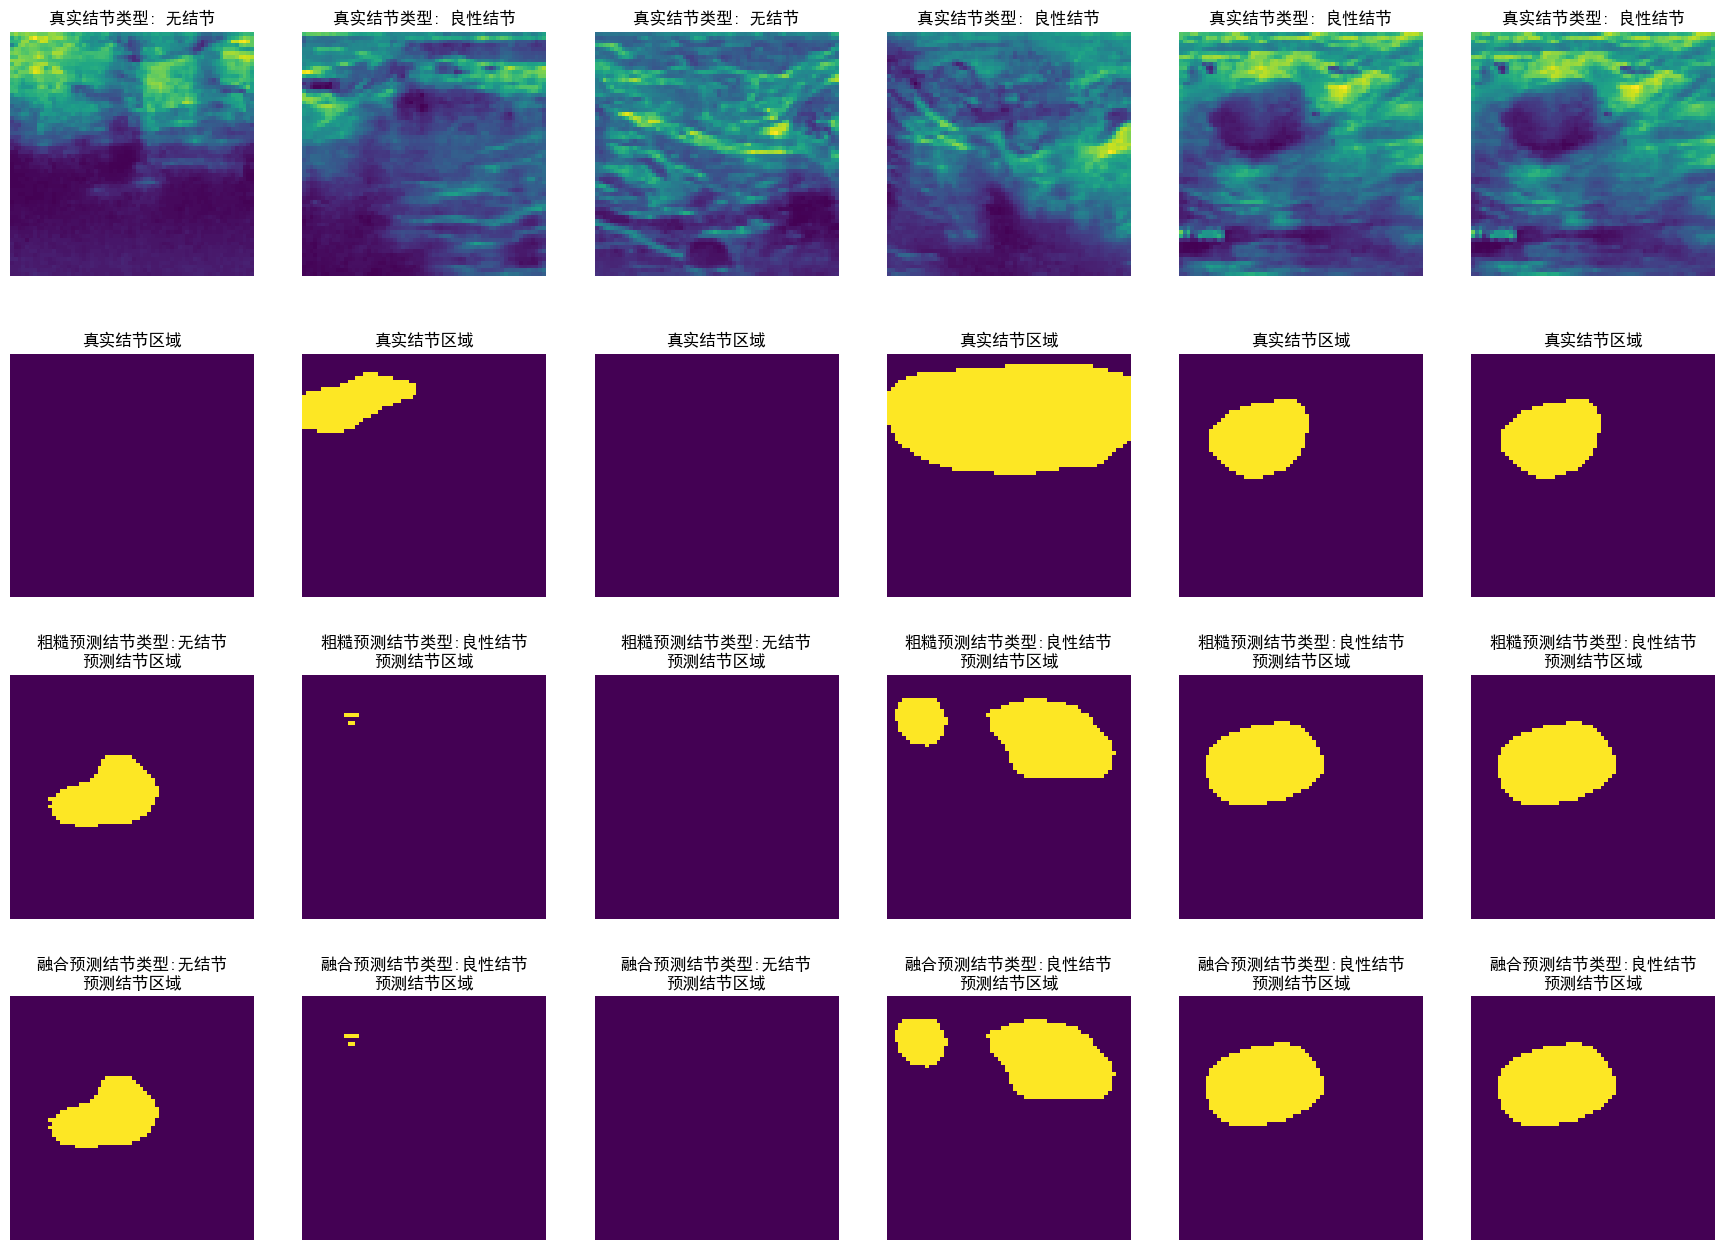

In [440]:

def predict(model,img,model2,mask):
    model2 = model2.eval()
    model = model.eval()
    label2 = model2(img.to(device).view(1,1,64,64))
    inx = model(label2.to(device).view(1,3),mask.to(device).view(1,1,64,64),)
    print(inx.detach().cpu(),label2.detach().cpu())
    inx = torch.argmax(inx).cpu()
    lable = inx_to_class_ch[int(inx)]
    return lable, inx_to_class_ch[int(torch.argmax(label2).cpu())]
    
fig, ax = plt.subplots(4, 6, figsize=(22, 16))
for this_ax in ax.ravel():
    this_ax.axis('off')

    
for counter, ind in enumerate(np.random.choice(np.arange(len(test_dataset)), 6)):
    image, mask, cancer_type = test_dataset[ind]
    
    ax[0, counter].imshow( image.permute(1,2,0) )
    ax[0, counter].set_title('真实结节类型: '+inx_to_class_ch[cancer_type])
    
    ax[1, counter].imshow( mask.permute(1,2,0) )
    ax[1, counter].set_title('真实结节区域')

    seg = UNet(torch.unsqueeze(image.to(device), 0))
    segmentation = (seg.detach().cpu() > 0.5)
    fussion_label, raw_label = predict(FusionNet,image,ClassprobabilityClassifyNetifyNet,seg)
    ax[2, counter].imshow( torch.squeeze(segmentation, 0).permute(1,2,0) )
    ax[2, counter].set_title('粗糙预测结节类型:'+raw_label +'\n预测结节区域')

    ax[3, counter].imshow( torch.squeeze(segmentation, 0).permute(1,2,0) )
    ax[3, counter].set_title('融合预测结节类型:'+fussion_label+'\n预测结节区域')

   

    #ax[5, counter].imshow(test_dataset[ind][0].permute(1,2,0) )
    #ax[5, counter].set_title('训练图像')